In [1]:
# Carga de librerías
import numpy as np
import tensorflow as tf
import PIL
import PIL.Image
import pathlib
import scipy as sp
import seaborn as sns
from itertools import product
import matplotlib.pyplot as plt
import pandas as pd
import tensorflow as tf
tf.compat.v1.logging.set_verbosity(tf.compat.v1.logging.ERROR)
import os


In [2]:
import pickle
import sys
from pathlib import Path

# Añadir el directorio raíz del proyecto a sys.path
module_path = Path('/Users/Cesar/Desktop/Proyecto-CSG/').resolve()
if module_path not in sys.path:
    sys.path.append(str(module_path))

# Añadir el directorio que contiene 'new_spectral_metric' a sys.path
new_spectral_metric_path = module_path / '/Users/Cesar/Desktop/Proyecto-CSG/new_spectral_metric/'
if new_spectral_metric_path not in sys.path:
    sys.path.append(str(new_spectral_metric_path))

from numpy.linalg import LinAlgError
from scipy.sparse.csgraph import laplacian
# from spectral_metric.lib import find_samples, compute_expectation_with_monter_carlo 
from new_spectral_metric.new_estimator import CumulativeGradientEstimator
from new_spectral_metric.new_visualize import make_graph
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Flatten, Conv2D, Dense, MaxPooling2D, Lambda
from tensorflow.keras import backend as K
from pathlib import Path
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from matplotlib.collections import LineCollection
from matplotlib.font_manager import FontProperties
from pathlib import Path


In [9]:
# Lectura de dataset

directorio_dataset = ('../Datasets/Cats and dogs - train')
directorio_dataset = pathlib.Path(directorio_dataset)

imagenes_cats = ('../Datasets/Cats and dogs - train/cats')
imagenes_cats = pathlib.Path(imagenes_cats)

imagenes_dogs = ('../Datasets/Cats and dogs - train/dogs')
imagenes_dogs = pathlib.Path(imagenes_dogs)

total_dataset = len(list(directorio_dataset.glob('*/*.jpg')))  # Cuenta la cantidad de imagenes del dataset (Aqui busca en las subcarpetas del directorio del dataset)
total_cats = len(list(imagenes_cats.glob('*.jpg')))  # Cuenta la cantidad de imagenes de la clase original (Aqui busca directamente en la carpeta cat)
total_dogs = len(list(imagenes_dogs.glob('*.jpg')))  # Cuenta la cantidad de imagenes de la clase corrupta (Aqui busca directamente en la carpeta cat_c_defocus_blur)

print(f"Total imagenes dataset: {total_dataset}")
print(f"Total imagenes cats: {total_cats}")
print(f"Total imagenes dogs: {total_dogs}")

Total imagenes dataset: 696
Total imagenes cats: 348
Total imagenes dogs: 348


In [10]:
# Dimensiones de imagen y tamaño de batch
img_height = 256
img_width = 256
#batch_size = len(list(data_dir.glob('*/*.png'))) # leer todas las imágenes al tiempo
batch_size = total_dataset

In [11]:

# Data splitting (entrenamiento y validación)
all_images_in_dataset = tf.keras.preprocessing.image_dataset_from_directory(
  directorio_dataset,
  #validation_split=0.2,
  color_mode='rgb',
  label_mode='int',
  #subset="training",
  #seed=123,
  shuffle=False,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 696 files belonging to 2 classes.


In [13]:
class_names = all_images_in_dataset.class_names
num_classes = len(class_names)  # get the number of the classes
print(f"Número de clases: {num_classes}")
print(f"Los nombres de las clases son: {class_names}")



Número de clases: 2
Los nombres de las clases son: ['cats', 'dogs']


In [14]:
# Revisar etiquetas de las imágenes
for images, labels in all_images_in_dataset:
    labels = labels.numpy() if hasattr(labels, 'numpy') else labels
    for label in labels:
        assert label in [0, 1], f"Etiqueta inesperada {label} en la imagen."


In [15]:
for images, labels0 in all_images_in_dataset.take(1):  # only take first element of dataset
    numpy_all_images = images.numpy()  # convertir el tensor de imágenes en un arreglo de numpy y ahora contiene las imágenes del conjunto de datos en formato de numpy.
    numpy_all_labels = labels0.numpy()  # convierte el tensor de etiquetas en un arreglo de numpy y ahora contiene las etiquetas del conjunto de datos en formato de numpy

numpy_all_images /= 255.0  # Scale the features to the [0, 1] range
print(numpy_all_images.shape)

(696, 256, 256, 3)


c:\Users\Cesar\AppData\Local\Programs\Python\Python312\Lib\site-packages\numpy\core\_methods.py:53: RuntimeWarning: overflow encountered in reduce
  return umr_prod(a, axis, dtype, out, keepdims, initial, where)
c:\Users\Cesar\AppData\Local\Programs\Python\Python312\Lib\site-packages\numpy\core\_methods.py:53: RuntimeWarning: overflow encountered in reduce
  return umr_prod(a, axis, dtype, out, keepdims, initial, where)
C:\Users\Cesar\Desktop\Proyecto-CSG\new_spectral_metric\new_visualize.py:48: RuntimeWarning: divide by zero encountered in divide
  similarities = difference.max() / difference * 100
C:\Users\Cesar\Desktop\Proyecto-CSG\new_spectral_metric\new_visualize.py:59: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


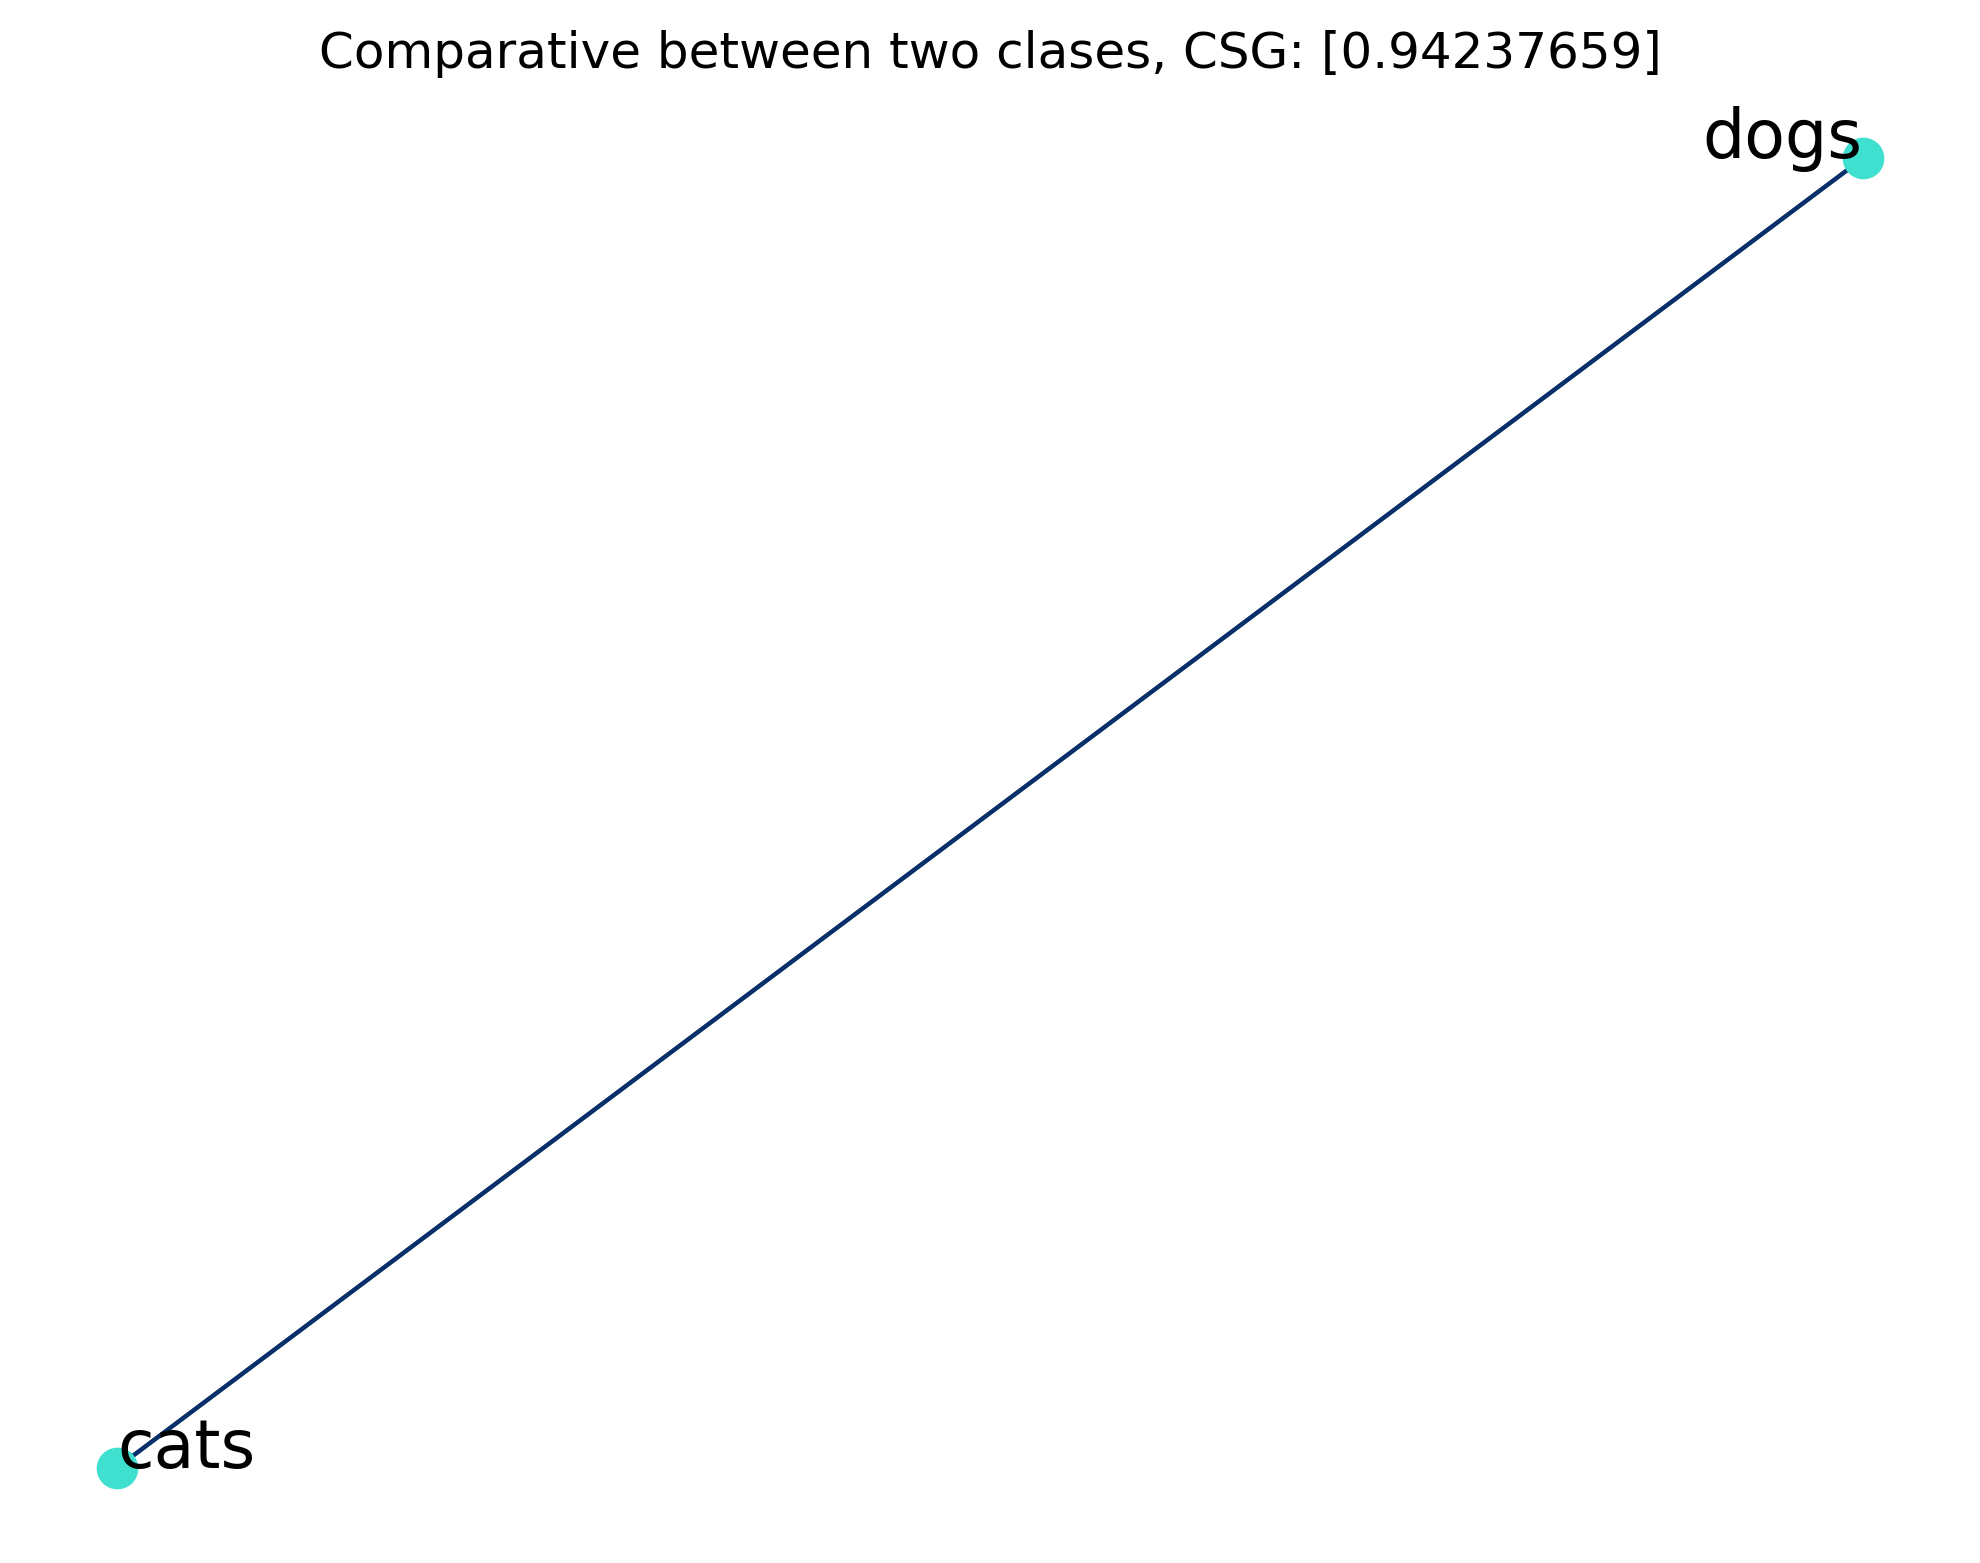

In [16]:
# Aplanar las imágenes
fully_dataset = numpy_all_images.reshape((numpy_all_images.shape[0], numpy_all_images.shape[1]*numpy_all_images.shape[2]*numpy_all_images.shape[3])) # es un arreglo bidimensional donde cada fila representa una imagen y cada columna representa un píxel de la imagen
fully_labels = numpy_all_labels.reshape(numpy_all_labels.shape[0],)


# Inicializar el estimador
estimator = CumulativeGradientEstimator(M_sample=348, k_nearest=10)
estimator.fit(data=fully_dataset, target=fully_labels)
csg = estimator.csg  # The actual complexity values.
estimator.evals, estimator.evecs  # The eigenvalues and vectors.

make_graph(estimator.difference, title="Comparative between two clases, CSG: "+str(csg), classes=class_names)

In [17]:
# Ordena los pares de clases en orden de similitud ascendente (menos similar primero)
pairs = list(zip(*np.unravel_index(np.argsort(estimator.W, axis=None), estimator.W.shape)))
pairs = [(original,corrupto) for original,corrupto in pairs if original != corrupto]

similitud_de_clases = pairs[0]
original, corrupto = similitud_de_clases  # Pares de clases menos similares

print("Calculo de similitud entre clases")
lst = []
for idx, (original,corrupto) in enumerate(pairs[::2][:1]):
    lst.append({"Clases a comparar" : f"{class_names[original]} <> {class_names[corrupto]}", "Similitud": estimator.W[original,corrupto]})
print(pd.DataFrame(lst))
print(estimator.W.shape)

Calculo de similitud entre clases
  Clases a comparar  Similitud
0      cats <> dogs   0.942377
(2, 2)


In [18]:

# Obtener todos los nombres de archivo en el dataset
filenames = [str(f) for f in directorio_dataset.glob('*/*.png')]

# Crear un mapeo de índices a nombres de archivo (solo el nombre de archivo, sin la ruta)
filenames_dict = {i: f.name for i, f in enumerate(directorio_dataset.glob('*/*.png'))}


In [19]:
for class_name, indices in estimator.class_indices.items():
    print(f"Clase: {class_names}, Número de muestras: {len(indices)}")


Clase: ['cats', 'dogs'], Número de muestras: 348
Clase: ['cats', 'dogs'], Número de muestras: 348


In [24]:

# Obtener todos los nombres de archivo en el dataset
filenames = [str(f) for f in directorio_dataset.glob('*/*.jpg')]

# Crear un mapeo de índices a nombres de archivo (solo el nombre de archivo, sin la ruta)
filenames_dict = {i: f.name for i, f in enumerate(directorio_dataset.glob('*/*.jpg'))}

def show_least_similar_using_P(source_intent, target_intent, estimator, class_names, filenames_dict):
    print(f"{class_names[source_intent]} <> {class_names[target_intent]}")
    
    # Obtener la matriz de similitud de las muestras entre las clases
    P = estimator.P[(source_intent, target_intent)]
    
    # Ordenar los índices según las similitudes (de menor a mayor)
    least_similar_indices = np.argsort(P, axis=None)
    
    # Conjunto para llevar un registro de los archivos ya mostrados
    shown_files = set()
    count = 0
    
    for idx in least_similar_indices:
        if count >= 10:
            break
        
        # Convertir el índice plano a índice 2D
        idx_2d = np.unravel_index(idx, P.shape)
        
        # Obtener los índices de las muestras en el dataset
        source_idx = estimator.class_indices[source_intent][idx_2d[0]]
        target_idx = estimator.class_indices[target_intent][idx_2d[1]]
        
        # Verificar que los índices estén dentro de los límites del dataset
        if source_idx < len(filenames_dict) and target_idx < len(filenames_dict):
            source_filename = filenames_dict[int(source_idx)]
            target_filename = filenames_dict[int(target_idx)]
            
            if source_filename not in shown_files and target_filename not in shown_files:
                shown_files.add(source_filename)
                shown_files.add(target_filename)
                
                value = P[idx_2d]
                print(f"\tNombre del archivo: {source_filename}, Clase: {class_names[source_intent]}, Similitud: {value:.4f}")
                count += 1

# Suponiendo que `pairs` contiene los índices de las clases en el formato [(0, 1)]
pairs = [(0, 1)]

first_pair = pairs[0]

# Mostrar los menos similares usando la matriz de pares (P)
show_least_similar_using_P(first_pair[0], first_pair[1], estimator, class_names, filenames_dict)
show_least_similar_using_P(first_pair[1], first_pair[0], estimator, class_names, filenames_dict)
for class_name, indices in estimator.class_indices.items():
    print(f"Clase: {class_name}, Número de muestras: {len(indices)}")


cats <> dogs
	Nombre del archivo: cat_224.jpg, Clase: cats, Similitud: 0.0674
	Nombre del archivo: cat_96.jpg, Clase: cats, Similitud: 0.1821
	Nombre del archivo: cat_435.jpg, Clase: cats, Similitud: 0.1844
	Nombre del archivo: cat_369.jpg, Clase: cats, Similitud: 0.1865
	Nombre del archivo: cat_50.jpg, Clase: cats, Similitud: 0.1887
	Nombre del archivo: cat_109.jpg, Clase: cats, Similitud: 0.2088
	Nombre del archivo: cat_546.jpg, Clase: cats, Similitud: 0.2406
	Nombre del archivo: cat_101.jpg, Clase: cats, Similitud: 0.2505
	Nombre del archivo: cat_303.jpg, Clase: cats, Similitud: 0.2658
	Nombre del archivo: cat_420.jpg, Clase: cats, Similitud: 0.3095
dogs <> cats
	Nombre del archivo: dog_403.jpg, Clase: dogs, Similitud: 0.0674
	Nombre del archivo: dog_505.jpg, Clase: dogs, Similitud: 0.1821
	Nombre del archivo: dog_197.jpg, Clase: dogs, Similitud: 0.1844
	Nombre del archivo: dog_412.jpg, Clase: dogs, Similitud: 0.1865
	Nombre del archivo: dog_344.jpg, Clase: dogs, Similitud: 0.1887
	

cats <> dogs
	Nombre del archivo: cat_224.jpg, Clase: cats, Similitud: 0.0674
	Nombre del archivo: dog_403.jpg, Clase: dogs, Similitud: 0.0674


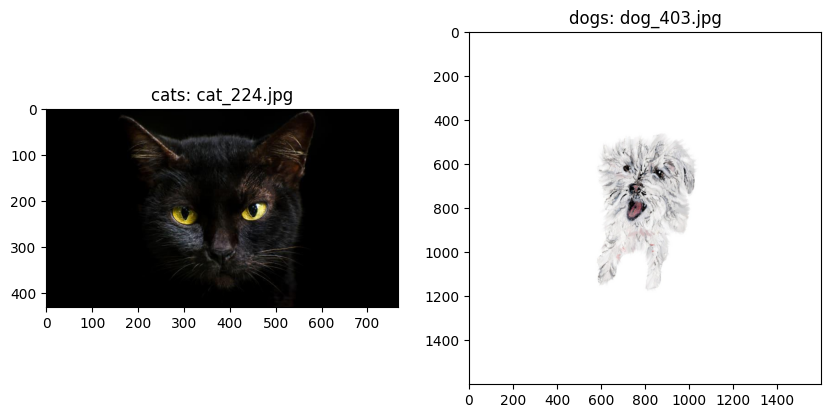

	Nombre del archivo: cat_96.jpg, Clase: cats, Similitud: 0.1821
	Nombre del archivo: dog_505.jpg, Clase: dogs, Similitud: 0.1821


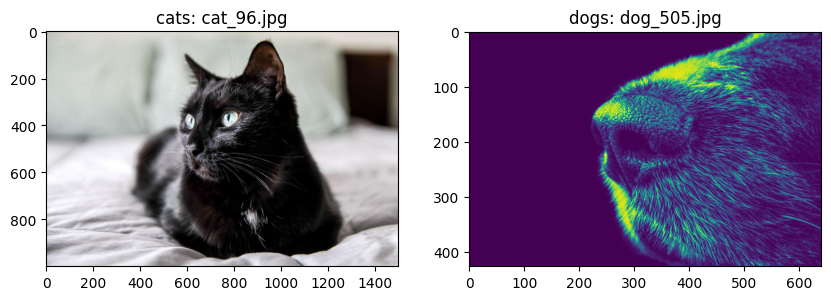

	Nombre del archivo: cat_435.jpg, Clase: cats, Similitud: 0.1844
	Nombre del archivo: dog_197.jpg, Clase: dogs, Similitud: 0.1844


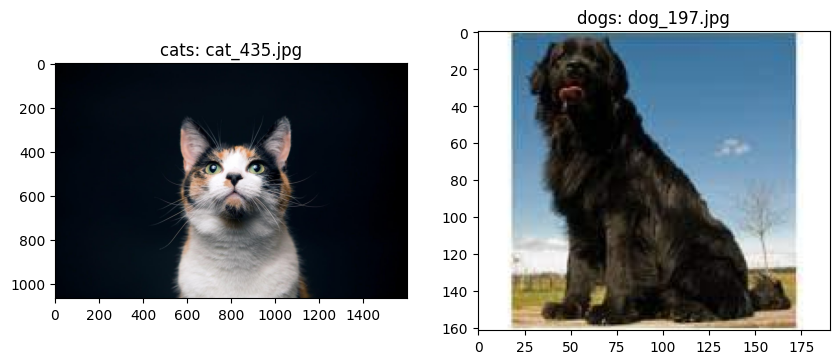

	Nombre del archivo: cat_369.jpg, Clase: cats, Similitud: 0.1865
	Nombre del archivo: dog_412.jpg, Clase: dogs, Similitud: 0.1865


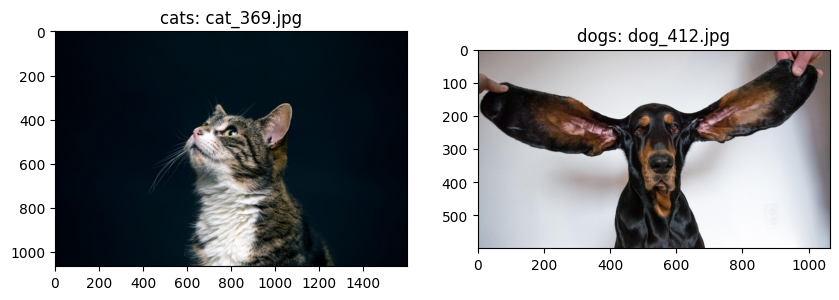

	Nombre del archivo: cat_50.jpg, Clase: cats, Similitud: 0.1887
	Nombre del archivo: dog_344.jpg, Clase: dogs, Similitud: 0.1887


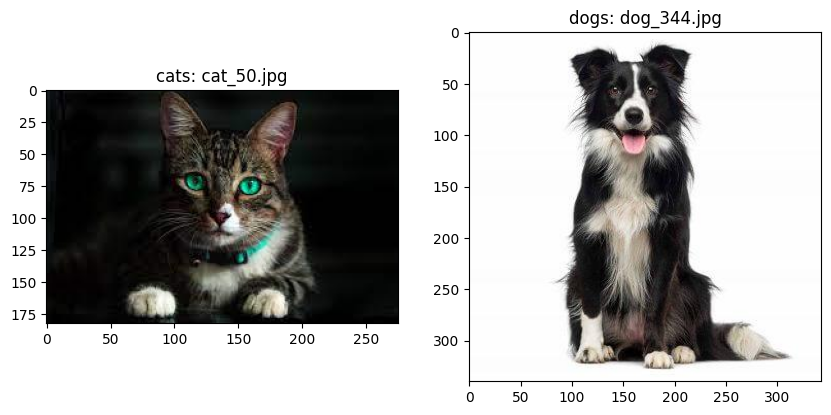

	Nombre del archivo: cat_109.jpg, Clase: cats, Similitud: 0.2088
	Nombre del archivo: dog_509.jpg, Clase: dogs, Similitud: 0.2088


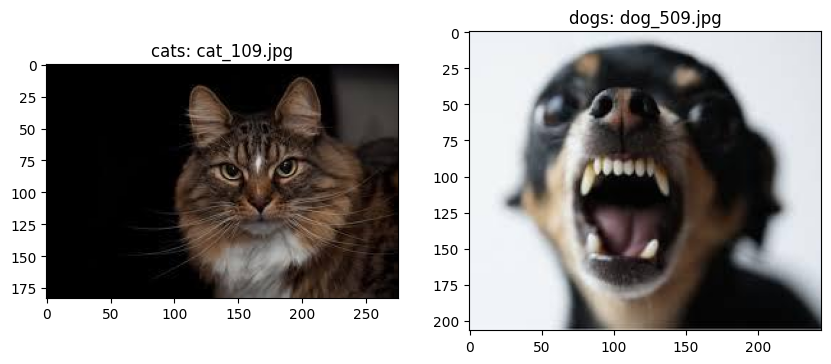

	Nombre del archivo: cat_546.jpg, Clase: cats, Similitud: 0.2406
	Nombre del archivo: dog_543.jpg, Clase: dogs, Similitud: 0.2406


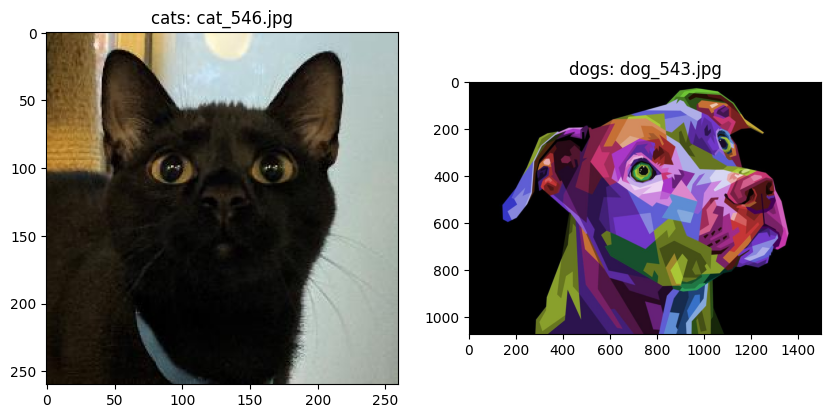

	Nombre del archivo: cat_101.jpg, Clase: cats, Similitud: 0.2505
	Nombre del archivo: dog_324.jpg, Clase: dogs, Similitud: 0.2505


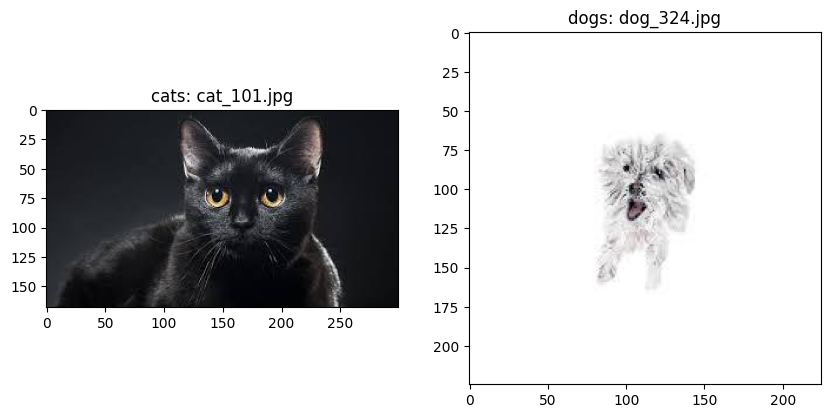

	Nombre del archivo: cat_303.jpg, Clase: cats, Similitud: 0.2658
	Nombre del archivo: dog_128.jpg, Clase: dogs, Similitud: 0.2658


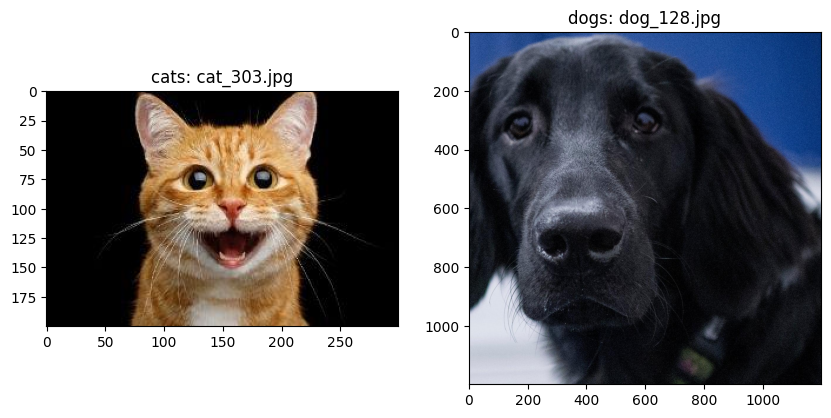

	Nombre del archivo: cat_420.jpg, Clase: cats, Similitud: 0.3095
	Nombre del archivo: dog_39.jpg, Clase: dogs, Similitud: 0.3095


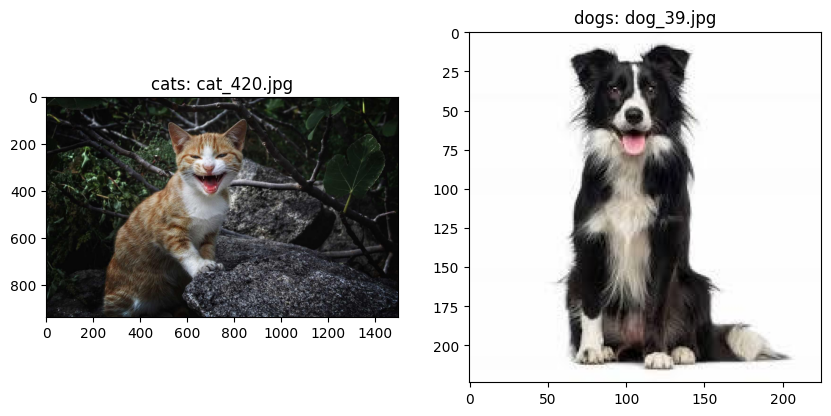

dogs <> cats
	Nombre del archivo: dog_403.jpg, Clase: dogs, Similitud: 0.0674
	Nombre del archivo: cat_224.jpg, Clase: cats, Similitud: 0.0674


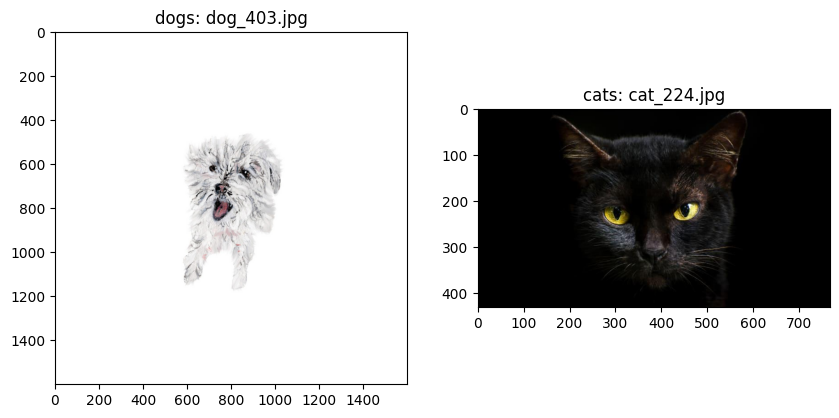

	Nombre del archivo: dog_505.jpg, Clase: dogs, Similitud: 0.1821
	Nombre del archivo: cat_96.jpg, Clase: cats, Similitud: 0.1821


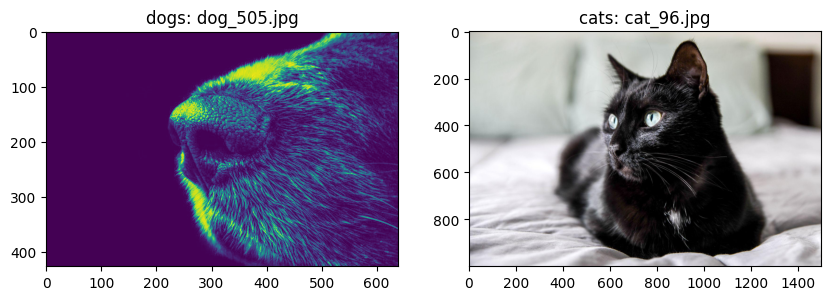

	Nombre del archivo: dog_197.jpg, Clase: dogs, Similitud: 0.1844
	Nombre del archivo: cat_435.jpg, Clase: cats, Similitud: 0.1844


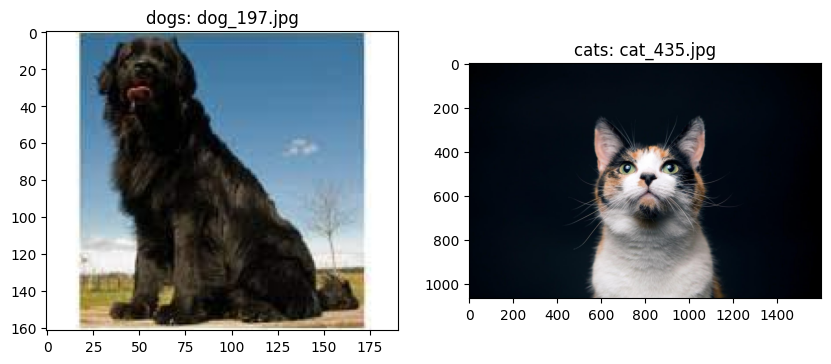

	Nombre del archivo: dog_412.jpg, Clase: dogs, Similitud: 0.1865
	Nombre del archivo: cat_369.jpg, Clase: cats, Similitud: 0.1865


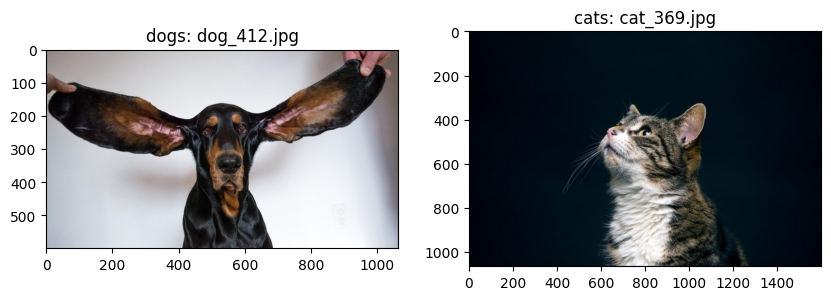

	Nombre del archivo: dog_344.jpg, Clase: dogs, Similitud: 0.1887
	Nombre del archivo: cat_50.jpg, Clase: cats, Similitud: 0.1887


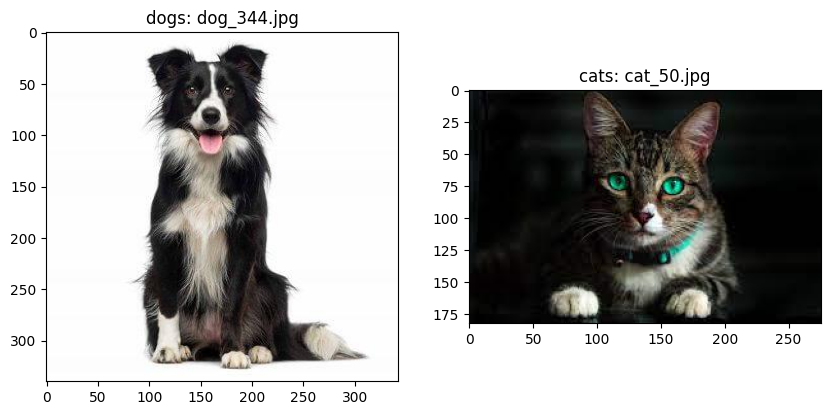

	Nombre del archivo: dog_509.jpg, Clase: dogs, Similitud: 0.2088
	Nombre del archivo: cat_109.jpg, Clase: cats, Similitud: 0.2088


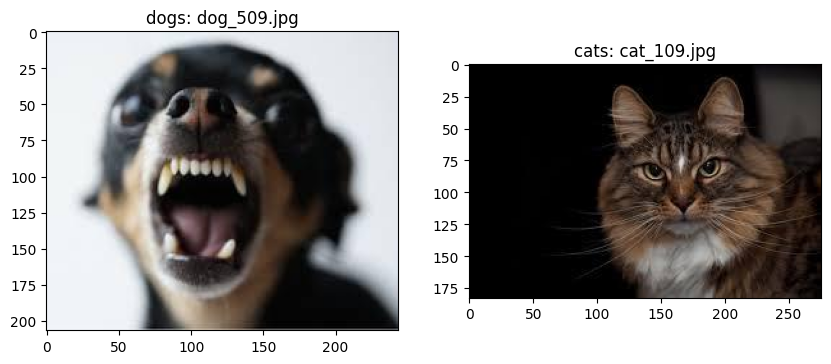

	Nombre del archivo: dog_543.jpg, Clase: dogs, Similitud: 0.2406
	Nombre del archivo: cat_546.jpg, Clase: cats, Similitud: 0.2406


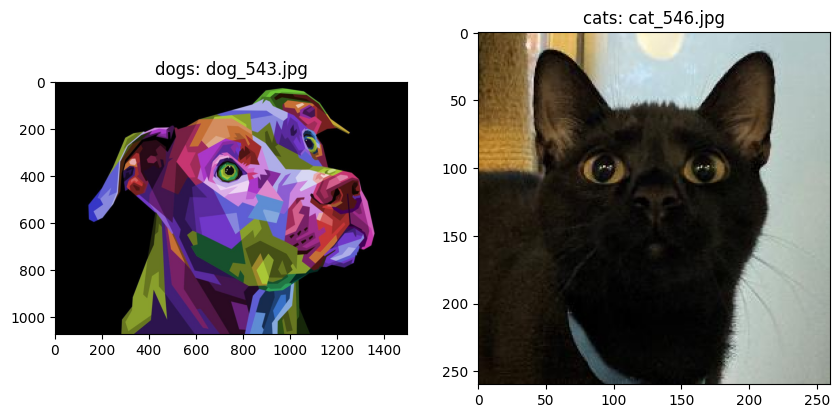

	Nombre del archivo: dog_324.jpg, Clase: dogs, Similitud: 0.2505
	Nombre del archivo: cat_101.jpg, Clase: cats, Similitud: 0.2505


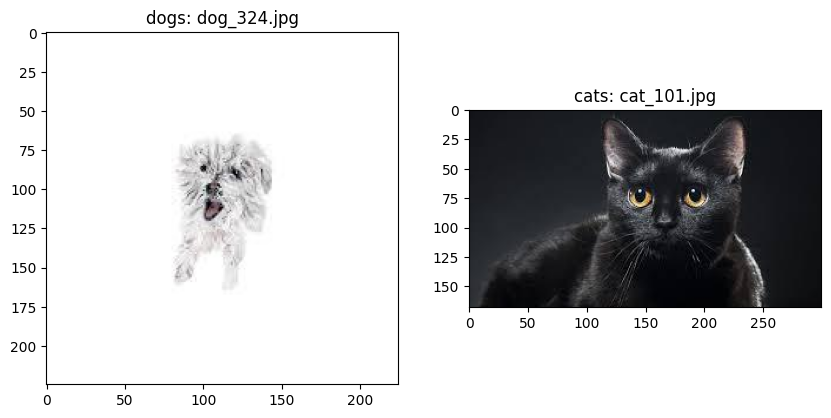

	Nombre del archivo: dog_128.jpg, Clase: dogs, Similitud: 0.2658
	Nombre del archivo: cat_303.jpg, Clase: cats, Similitud: 0.2658


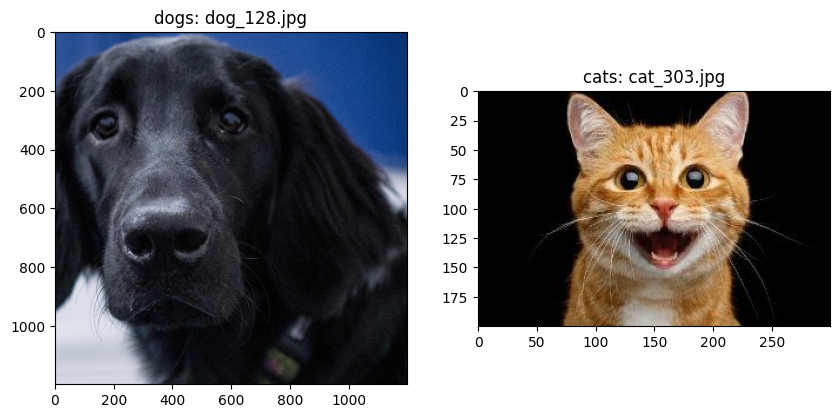

	Nombre del archivo: dog_39.jpg, Clase: dogs, Similitud: 0.3095
	Nombre del archivo: cat_420.jpg, Clase: cats, Similitud: 0.3095


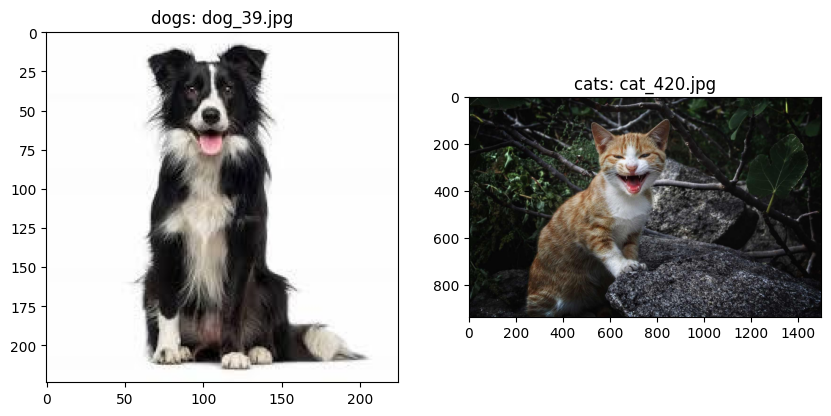

Clase: 0, Número de muestras: 348
Clase: 1, Número de muestras: 348


In [27]:
import numpy as np
import matplotlib.pyplot as plt
import pathlib

# Obtener todos los nombres de archivo en el dataset
filenames = [str(f) for f in directorio_dataset.glob('*/*.jpg')]

# Crear un mapeo de índices a nombres de archivo (solo el nombre de archivo, sin la ruta)
filenames_dict = {i: f for i, f in enumerate(directorio_dataset.glob('*/*.jpg'))}

def show_least_similar_using_P(source_intent, target_intent, estimator, class_names, filenames_dict):
    print(f"{class_names[source_intent]} <> {class_names[target_intent]}")
    
    # Obtener la matriz de similitud de las muestras entre las clases
    P = estimator.P[(source_intent, target_intent)]
    
    # Ordenar los índices según las similitudes (de menor a mayor)
    least_similar_indices = np.argsort(P, axis=None)
    
    # Conjunto para llevar un registro de los archivos ya mostrados
    shown_files = set()
    count = 0
    
    for idx in least_similar_indices:
        if count >= 10:
            break
        
        # Convertir el índice plano a índice 2D
        idx_2d = np.unravel_index(idx, P.shape)
        
        # Obtener los índices de las muestras en el dataset
        source_idx = estimator.class_indices[source_intent][idx_2d[0]]
        target_idx = estimator.class_indices[target_intent][idx_2d[1]]
        
        # Verificar que los índices estén dentro de los límites del dataset
        if source_idx < len(filenames_dict) and target_idx < len(filenames_dict):
            source_filename = filenames_dict[int(source_idx)]
            target_filename = filenames_dict[int(target_idx)]
            
            if source_filename not in shown_files and target_filename not in shown_files:
                shown_files.add(source_filename)
                shown_files.add(target_filename)
                
                value = P[idx_2d]
                print(f"\tNombre del archivo: {source_filename.name}, Clase: {class_names[source_intent]}, Similitud: {value:.4f}")
                print(f"\tNombre del archivo: {target_filename.name}, Clase: {class_names[target_intent]}, Similitud: {value:.4f}")
                
                img_source = plt.imread(source_filename)
                img_target = plt.imread(target_filename)
                
                fig, axs = plt.subplots(1, 2, figsize=(10, 5))
                axs[0].imshow(img_source)
                axs[0].set_title(f"{class_names[source_intent]}: {source_filename.name}")
                axs[1].imshow(img_target)
                axs[1].set_title(f"{class_names[target_intent]}: {target_filename.name}")
                plt.show()
                
                count += 1

# Suponiendo que `pairs` contiene los índices de las clases en el formato [(0, 1)]
pairs = [(0, 1)]

first_pair = pairs[0]

# Mostrar los menos similares usando la matriz de pares (P)
show_least_similar_using_P(first_pair[0], first_pair[1], estimator, class_names, filenames_dict)
show_least_similar_using_P(first_pair[1], first_pair[0], estimator, class_names, filenames_dict)

for class_name, indices in estimator.class_indices.items():
    print(f"Clase: {class_name}, Número de muestras: {len(indices)}")


In [29]:
import numpy as np

# Supongamos que tienes las siguientes listas de características de las muestras de cada clase
cats_features = np.random.rand(348, 256)  # 348 muestras con características de dimensión 256
dogs_features = np.random.rand(348, 256)  # 348 muestras con características de dimensión 256

# Función de similitud (por ejemplo, producto punto)
def similitud(a, b):
    return np.dot(a, b)

# Crear la matriz P
P = np.zeros((348, 348))

# Llenar la matriz P
for i in range(348):
    for j in range(348):
        P[i, j] = similitud(cats_features[i], dogs_features[j])

print(P)


[[62.4563917  65.47393804 67.78834164 ... 63.59921926 62.80522405
  65.58321387]
 [57.65262125 58.10181839 60.1567362  ... 57.0890805  57.91699683
  60.84809753]
 [65.76595038 64.65200762 71.48427546 ... 67.56925135 65.47502585
  67.72047189]
 ...
 [62.87407059 62.4182284  65.27919016 ... 60.97763998 60.81342269
  61.67098991]
 [65.36439011 64.79766896 69.10960238 ... 64.55066425 64.31780743
  64.33201295]
 [59.09105703 61.90333815 62.97410965 ... 58.71997378 61.00966941
  61.33858902]]


In [37]:
# Acceder a la matriz M después de ajustar el modelo
M = estimator.M

# Ordenar los índices según las similitudes (de menor a mayor)
least_similar_indices = np.argsort(M, axis=None)

# Conjunto para llevar un registro de los archivos ya mostrados
shown_files = set()
count = 0

# Crear un diccionario de nombres de archivo y clases
filenames_dict = {i: f.name for i, f in enumerate(directorio_dataset.glob('*/*.jpg'))}
class_names_list = ['cats' if label == 0 else 'dogs' for label in fully_labels]

# Mostrar las 10 muestras menos similares
for idx in least_similar_indices:
    if count >= 10:
        break

    # Convertir el índice plano a índice 2D
    idx_2d = np.unravel_index(idx, M.shape)

    # Obtener los índices de las muestras en el dataset
    source_idx = idx_2d[0]
    target_idx = idx_2d[1]

    # Verificar que los índices estén dentro de los límites del dataset
    if source_idx < len(filenames_dict) and target_idx < len(filenames_dict):
        source_filename = filenames_dict[int(source_idx)]
        target_filename = filenames_dict[int(target_idx)]

        if (source_filename, target_filename) not in shown_files and (target_filename, source_filename) not in shown_files:
            shown_files.add((source_filename, target_filename))
            shown_files.add((target_filename, source_filename))

            value = M[idx_2d]
            print(f"\tNombre del archivo: {source_filename}, Clase: {class_names_list[source_idx]}, Similitud: {value:.4f}")
            print(f"\tNombre del archivo: {target_filename}, Clase: {class_names_list[target_idx]}, Similitud: {value:.4f}")
            count += 1

	Nombre del archivo: cat_544.jpg, Clase: cats, Similitud: 0.0508
	Nombre del archivo: cat_224.jpg, Clase: cats, Similitud: 0.0508
	Nombre del archivo: dog_403.jpg, Clase: dogs, Similitud: 0.0674
	Nombre del archivo: cat_224.jpg, Clase: cats, Similitud: 0.0674
	Nombre del archivo: dog_324.jpg, Clase: dogs, Similitud: 0.0675
	Nombre del archivo: cat_224.jpg, Clase: cats, Similitud: 0.0675
	Nombre del archivo: cat_224.jpg, Clase: cats, Similitud: 0.0693
	Nombre del archivo: cat_387.jpg, Clase: cats, Similitud: 0.0693
	Nombre del archivo: cat_224.jpg, Clase: cats, Similitud: 0.0693
	Nombre del archivo: cat_446.jpg, Clase: cats, Similitud: 0.0693
	Nombre del archivo: cat_224.jpg, Clase: cats, Similitud: 0.0694
	Nombre del archivo: dog_546.jpg, Clase: dogs, Similitud: 0.0694
	Nombre del archivo: cat_224.jpg, Clase: cats, Similitud: 0.0700
	Nombre del archivo: cat_203.jpg, Clase: cats, Similitud: 0.0700
	Nombre del archivo: cat_224.jpg, Clase: cats, Similitud: 0.0702
	Nombre del archivo: cat_